<a href="https://colab.research.google.com/github/KRISHNAREDDYMADIREDDY-23035965/data_mining_final/blob/main/Datamining50_kitti.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install pgmpy

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 16.8 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler, KBinsDiscretizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, roc_curve, auc, ConfusionMatrixDisplay
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import VarianceThreshold
from pgmpy.models import BayesianNetwork
from pgmpy.estimators import HillClimbSearch, K2Score
from pgmpy.inference import VariableElimination
import matplotlib.pyplot as plt
from joblib import Parallel, delayed
import warnings

warnings.filterwarnings("ignore")

# Load dataset from UCI repository
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/mushroom/agaricus-lepiota.data"
columns = [
    "class", "cap-shape", "cap-surface", "cap-color", "bruises", "odor",
    "gill-attachment", "gill-spacing", "gill-size", "gill-color", "stalk-shape",
    "stalk-root", "stalk-surface-above-ring", "stalk-surface-below-ring",
    "stalk-color-above-ring", "stalk-color-below-ring", "veil-type", "veil-color",
    "ring-number", "ring-type", "spore-print-color", "population", "habitat"
]

# Load the data
data = pd.read_csv(url, header=None, names=columns)

# Count the total number of records in the dataset
total_records = len(data)
print(f"Total number of records: {total_records}")

Total number of records: 8124


In [3]:
# Replace '?' with None and drop rows with missing values
data = data.replace('?', None).dropna()

# Encode all categorical columns into numeric values
encoder = LabelEncoder()
for col in data.columns:
    data[col] = encoder.fit_transform(data[col])

# Separate features (X) and target (y)
X = data.drop(columns=["class"])
y = data["class"]


In [4]:
# Function for single instance inference
def infer_single_instance(i, discretized_data, inference, model):
    evidence_dict = {key: value for key, value in discretized_data.iloc[i, 1:].to_dict().items() if key in model.nodes()}
    try:
        prediction = inference.map_query(variables=["class"], evidence=evidence_dict)
        return prediction["class"] == discretized_data.iloc[i]["class"]
    except Exception:
        return False

# Step 1: Remove low-variance features
variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)
X_reduced = pd.DataFrame(selector.fit_transform(X), columns=X.columns[selector.get_support()])

# Step 2: Discretize features (reduce bins to speed up computation)
discretizer = KBinsDiscretizer(n_bins=2, encode='ordinal', strategy='uniform')
X_discretized = pd.DataFrame(discretizer.fit_transform(X_reduced), columns=X_reduced.columns)

# Step 3: Combine target and features
discretized_data = pd.concat([pd.DataFrame({"class": y}).reset_index(drop=True), X_discretized.reset_index(drop=True)], axis=1)

# Step 4: Estimate Bayesian Network structure with a limit on complexity
estimator = HillClimbSearch(discretized_data)
best_model = estimator.estimate(scoring_method=K2Score(discretized_data), max_indegree=2)  # Limit maximum parents per node

# Step 5: Train the Bayesian Network
model = BayesianNetwork(best_model.edges())
model.fit(discretized_data)

# Step 6: Initialize Bayesian inference
inference = VariableElimination(model)

# Step 7: Parallelized inference with batched processing
batch_size = 100
correct_predictions = 0

for batch_start in range(0, len(discretized_data), batch_size):
    batch_end = min(batch_start + batch_size, len(discretized_data))
    correct_predictions += sum(Parallel(n_jobs=-1)(
        delayed(infer_single_instance)(i, discretized_data, inference, model)
        for i in range(batch_start, batch_end)
    ))

# Step 8: Calculate and display accuracy
accuracy_bn = correct_predictions / len(discretized_data)
print("\nBayesian Network Accuracy:", accuracy_bn)


  0%|          | 0/1000000 [00:00<?, ?it/s]


Bayesian Network Accuracy: 0.9014883061658399


In [5]:
# Scale the features for supervised learning models
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)
# Train Decision Tree Classifier
dt_model = DecisionTreeClassifier(random_state=42, max_depth=5)
dt_model.fit(X_train, y_train)

# Predict on the test set
y_pred_dt = dt_model.predict(X_test)

# Calculate Decision Tree accuracy
accuracy_dt = accuracy_score(y_test, y_pred_dt)
print("\nDecision Tree Accuracy:", accuracy_dt)


Decision Tree Accuracy: 0.9991142604074402


In [6]:
# Train Random Forest Classifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Calculate Random Forest accuracy
accuracy_rf = accuracy_score(y_test, y_pred_rf)
print("\nRandom Forest Accuracy:", accuracy_rf)


Random Forest Accuracy: 1.0


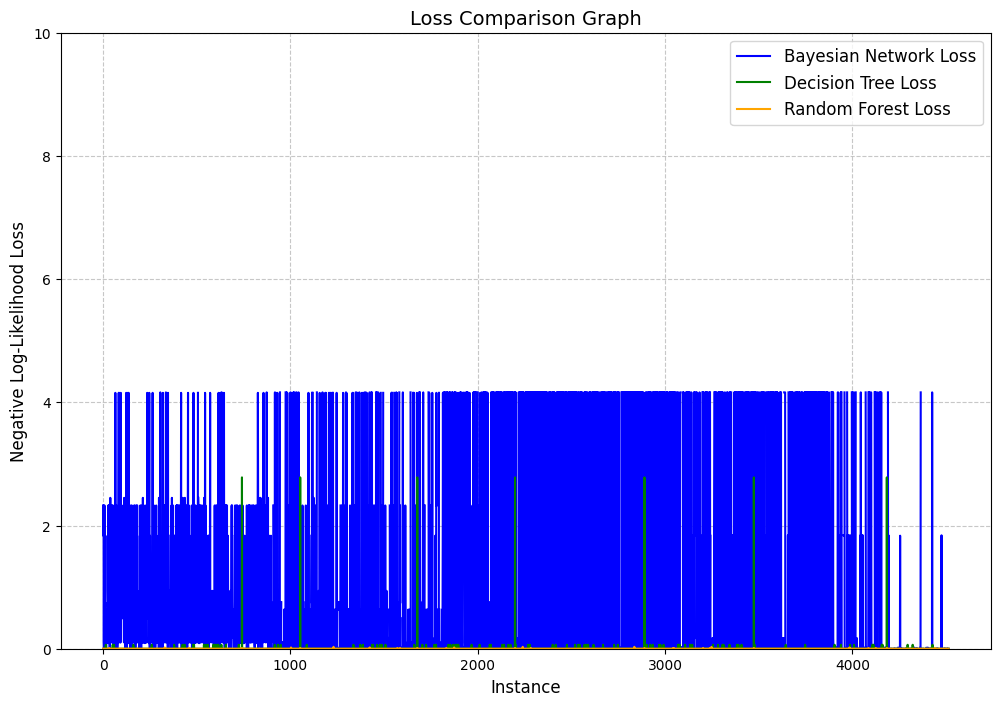

In [7]:
# Calculate and plot loss values
loss_values_bn, loss_values_dt, loss_values_rf = [], [], []
y_pred_prob_dt = dt_model.predict_proba(X_train)
y_pred_prob_rf = rf_model.predict_proba(X_train)

for i, true_class in enumerate(y_train):
    # Bayesian Network loss
    evidence_dict = X_discretized.iloc[i].to_dict()
    query_result = inference.query(variables=["class"], evidence=evidence_dict)
    predicted_prob_bn = query_result.values[true_class]
    loss_values_bn.append(-np.log(predicted_prob_bn))

    # Decision Tree loss
    predicted_prob_dt = y_pred_prob_dt[i][true_class]
    loss_values_dt.append(-np.log(predicted_prob_dt))

    # Random Forest loss
    predicted_prob_rf = y_pred_prob_rf[i][true_class]
    loss_values_rf.append(-np.log(predicted_prob_rf))

# Plot combined loss graph
plt.figure(figsize=(12, 8))
plt.plot(range(len(loss_values_bn)), loss_values_bn, color='blue', label='Bayesian Network Loss')
plt.plot(range(len(loss_values_dt)), loss_values_dt, color='green', label='Decision Tree Loss')
plt.plot(range(len(loss_values_rf)), loss_values_rf, color='orange', label='Random Forest Loss')
plt.title("Loss Comparison Graph", fontsize=14)
plt.xlabel("Instance", fontsize=12)
plt.ylabel("Negative Log-Likelihood Loss", fontsize=12)
plt.legend(fontsize=12)
plt.ylim(0,10)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()



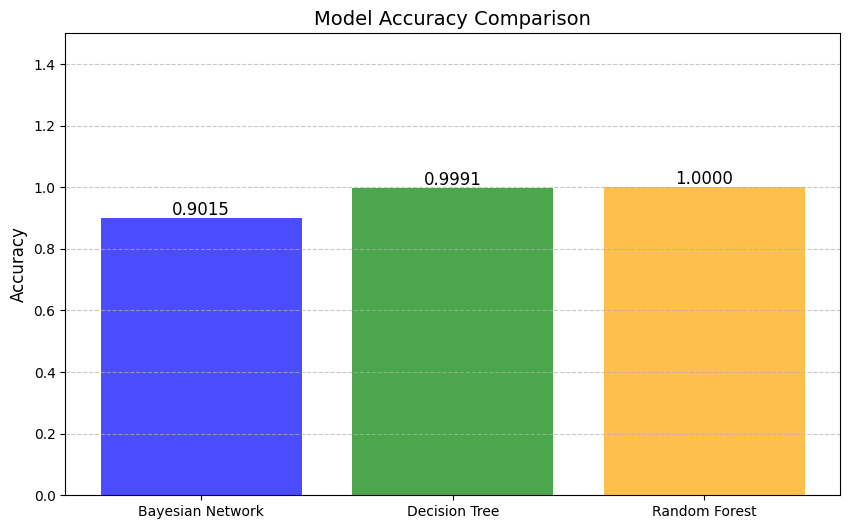

In [8]:
# Accuracies of the models and Plot the accuracies
models = ['Bayesian Network', 'Decision Tree', 'Random Forest']
accuracies = [accuracy_bn, accuracy_dt, accuracy_rf]
plt.figure(figsize=(10, 6))
bars = plt.bar(models, accuracies, color=['blue', 'green', 'orange'], alpha=0.7)
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.01, f"{yval:.4f}", ha='center', fontsize=12)

plt.title("Model Accuracy Comparison", fontsize=14)
plt.ylabel("Accuracy", fontsize=12)
plt.ylim(0,1.5)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

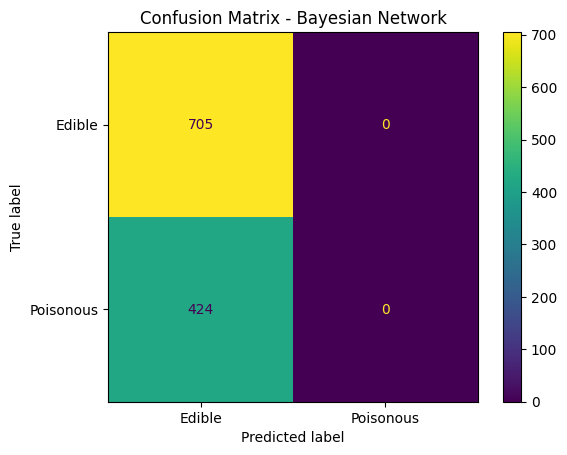

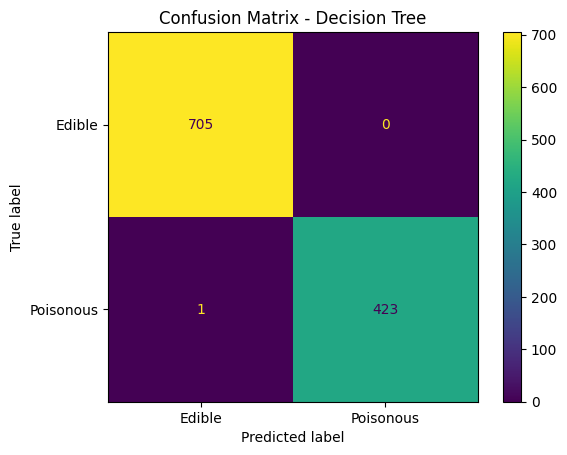

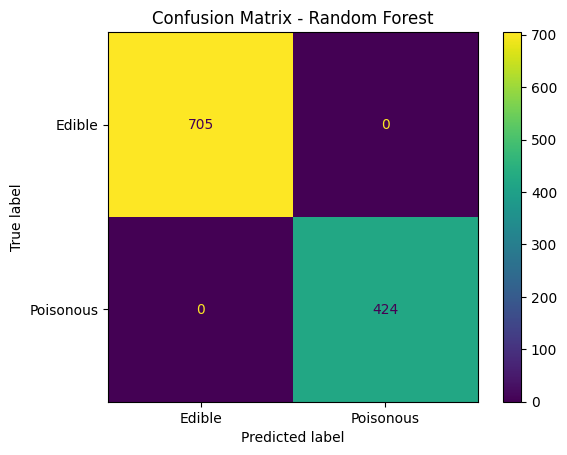

In [9]:
# Discretize the test set to align with Bayesian Network requirements
def discretize_test_set(X_test):
    """
    Discretize the test set features to match the Bayesian Network format.

    Args:
        X_test (pd.DataFrame): Test set features.

    Returns:
        pd.DataFrame: Discretized test set features.
    """
    discretizer = KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform")
    return pd.DataFrame(discretizer.fit_transform(X_test), columns=X_test.columns)


# Ensure X_test_discretized corresponds to the same test set as y_test
X_test_discretized = discretize_test_set(pd.DataFrame(X_test, columns=X.columns))

# Predict using Bayesian Network
y_pred_bn = []
for i in range(len(y_test)):
    evidence_dict = X_test_discretized.iloc[i].to_dict()
    try:
        query_result = inference.map_query(variables=["class"], evidence=evidence_dict)
        y_pred_bn.append(query_result["class"])
    except Exception:
        y_pred_bn.append(0)  # Handle inference failures gracefully

# Predict using Decision Tree and Random Forest
y_pred_dt = dt_model.predict(X_test)
y_pred_rf = rf_model.predict(X_test)

# Ensure all predictions have the same length as y_test
assert len(y_test) == len(y_pred_bn) == len(y_pred_dt) == len(y_pred_rf), "Inconsistent lengths detected!"

# Plot Confusion Matrices for all models
model_predictions = {
    "Bayesian Network": y_pred_bn,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf
}

for model_name, y_pred in model_predictions.items():
    ConfusionMatrixDisplay.from_predictions(y_test, y_pred, display_labels=["Edible", "Poisonous"])
    plt.title(f"Confusion Matrix - {model_name}")
    plt.show()


<Figure size 1400x800 with 0 Axes>

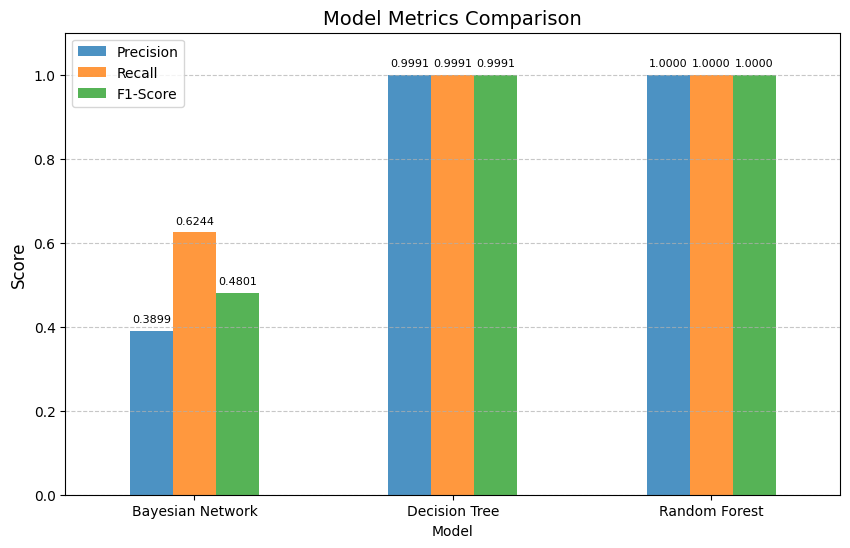

In [10]:
# Calculate performance metrics for all models
# Ensure y_pred_bn, y_pred_dt, and y_pred_rf are already computed in earlier steps
from sklearn.metrics import precision_score, recall_score, f1_score

# Define model predictions and corresponding names
model_predictions = {
    "Bayesian Network": y_pred_bn,
    "Decision Tree": y_pred_dt,
    "Random Forest": y_pred_rf
}

# Initialize metrics dictionary
metrics = {
    "Model": [],
    "Precision": [],
    "Recall": [],
    "F1-Score": []
}

# Calculate metrics for each model
for model_name, y_pred in model_predictions.items():
    metrics["Model"].append(model_name)
    metrics["Precision"].append(precision_score(y_test, y_pred, zero_division=0, average="weighted"))
    metrics["Recall"].append(recall_score(y_test, y_pred, zero_division=0, average="weighted"))
    metrics["F1-Score"].append(f1_score(y_test, y_pred, zero_division=0, average="weighted"))

# Create a DataFrame for metrics
metrics_df = pd.DataFrame(metrics)

# Plot metrics comparison
plt.figure(figsize=(14, 8))
ax = metrics_df.set_index("Model").plot(kind="bar", figsize=(10, 6), alpha=0.8, rot=0)

# Annotate bars with metric values
for p in ax.patches:
    ax.text(
        p.get_x() + p.get_width() / 2,
        p.get_height() + 0.02,
        f"{p.get_height():.4f}",
        ha="center",
        fontsize=8
    )

# Add titles, labels, and grid for better visualization
plt.title("Model Metrics Comparison", fontsize=14)
plt.ylabel("Score", fontsize=12)
plt.ylim(0, 1.1)  # Adjust to ensure all bars are visible
plt.grid(axis="y", linestyle="--", alpha=0.7)
plt.legend(loc="upper left", fontsize=10)
plt.show()


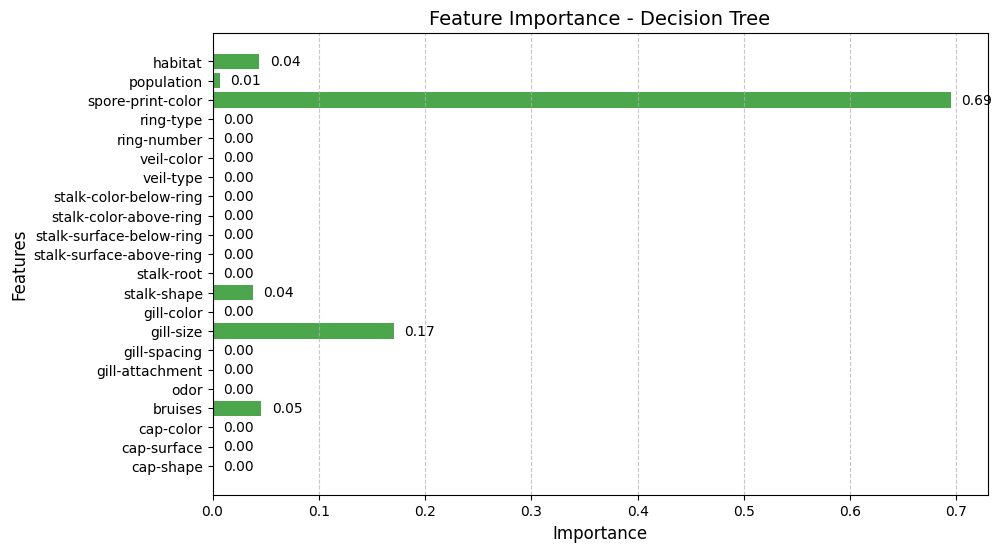

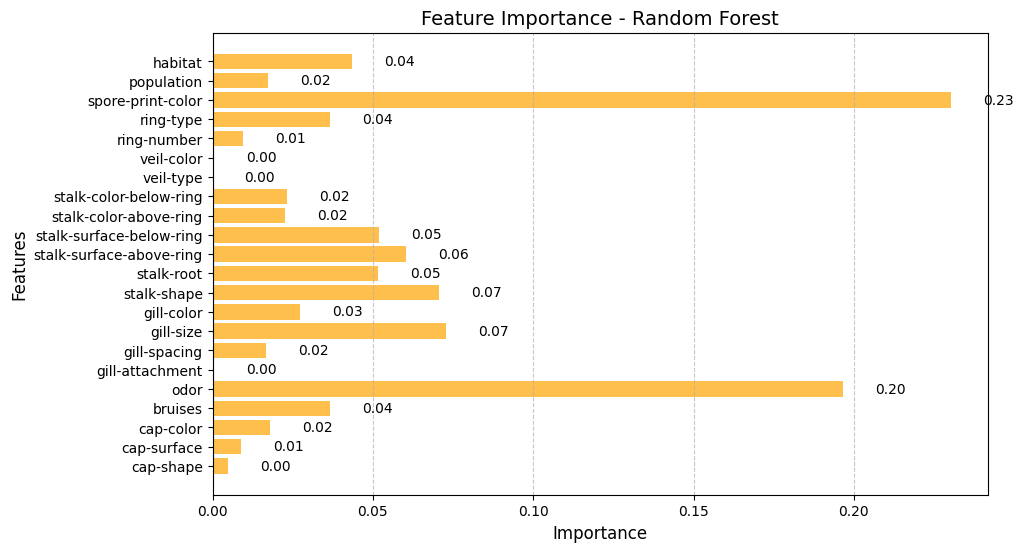

In [11]:
# Decision Tree Feature Importance
plt.figure(figsize=(10, 6))
bars_dt = plt.barh(X.columns, dt_model.feature_importances_, color='green', alpha=0.7)
for bar, feature in zip(bars_dt, X.columns):
    plt.text(
        bar.get_width() + 0.01,
        bar.get_y() + bar.get_height() / 2,
        f"{bar.get_width():.2f}",
        va="center",
        fontsize=10
    )
plt.title("Feature Importance - Decision Tree", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

# Random Forest Feature Importance
plt.figure(figsize=(10, 6))
bars_rf = plt.barh(X.columns, rf_model.feature_importances_, color='orange', alpha=0.7)
for bar, feature in zip(bars_rf, X.columns):
    plt.text(
        bar.get_width() + 0.01,  # Slightly to the right of the bar
        bar.get_y() + bar.get_height() / 2,  # Vertically center the text
        f"{bar.get_width():.2f}",  # Format the value to 2 decimal places
        va="center",
        fontsize=10
    )
plt.title("Feature Importance - Random Forest", fontsize=14)
plt.xlabel("Importance", fontsize=12)
plt.ylabel("Features", fontsize=12)
plt.grid(axis="x", linestyle="--", alpha=0.7)
plt.show()

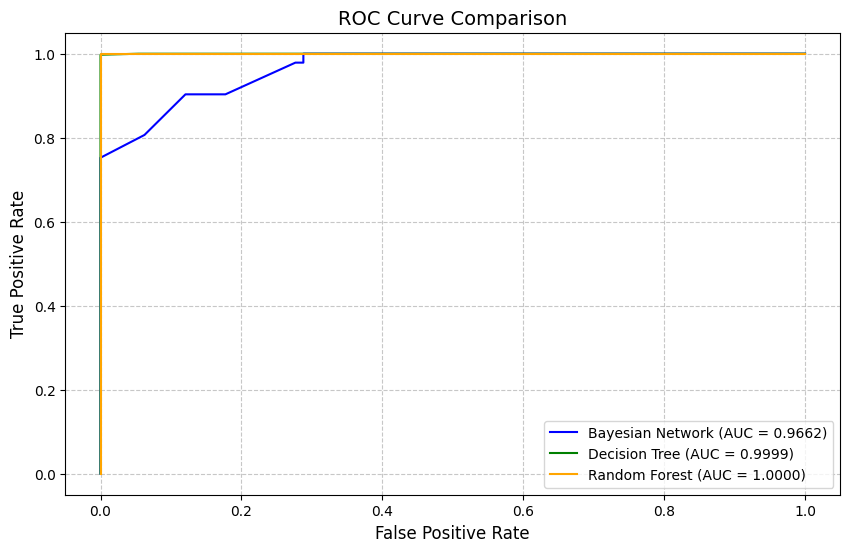

In [12]:
# Function to calculate Bayesian Network probabilities
def calculate_bn_probabilities(discretized_data, model, inference):
    """
    Calculate probabilities for class=1 using Bayesian Network.

    Args:
        discretized_data (pd.DataFrame): Discretized dataset with class and features.
        model (BayesianNetwork): Trained Bayesian Network model.
        inference (VariableElimination): Inference object for Bayesian Network.

    Returns:
        list: Probabilities for class=1 for each instance in the test set.
    """
    probs = []
    for i in range(len(discretized_data)):
        # Prepare evidence dictionary for inference
        evidence_dict = {key: value for key, value in discretized_data.iloc[i, 1:].to_dict().items() if key in model.nodes()}
        try:
            # Query the Bayesian Network
            query_result = inference.query(variables=["class"], evidence=evidence_dict)
            probs.append(query_result.values[1])  # Probability for class=1
        except Exception:
            probs.append(0.5)  # Assign 0.5 for errors to avoid crashes
    return probs

# Function to discretize the test set for Bayesian Network
def discretize_test_set(X_test):
    """
    Discretize the test set features to match the Bayesian Network format.

    Args:
        X_test (pd.DataFrame): Test set features.

    Returns:
        pd.DataFrame: Discretized test set features.
    """
    discretizer = KBinsDiscretizer(n_bins=2, encode="ordinal", strategy="uniform")
    return pd.DataFrame(discretizer.fit_transform(X_test), columns=X_test.columns)

# Convert X_test back to a DataFrame if needed
if isinstance(X_test, np.ndarray):
    X_test = pd.DataFrame(X_test, columns=X.columns)

# Discretize the test set
discretized_test_data = discretize_test_set(X_test)

# Calculate Bayesian Network probabilities using the test data
probs_bn = calculate_bn_probabilities(
    pd.concat([y_test.reset_index(drop=True), discretized_test_data], axis=1), model, inference
)

# Plot combined ROC curves
def plot_roc_curves(y_test, X_test, dt_model, rf_model, discretized_data, model, inference):
    """
    Plot combined ROC curves for Bayesian Network, Decision Tree, and Random Forest.

    Args:
        y_test (pd.Series): True labels for the test set.
        X_test (pd.DataFrame): Test set features.
        dt_model (DecisionTreeClassifier): Pre-trained Decision Tree model.
        rf_model (RandomForestClassifier): Pre-trained Random Forest model.
        discretized_data (pd.DataFrame): Discretized test data for Bayesian Network.
        model (BayesianNetwork): Pre-trained Bayesian Network model.
        inference (VariableElimination): Bayesian Network inference object.
    """
    from sklearn.metrics import roc_curve, auc

    # Bayesian Network probabilities
    probs_bn = calculate_bn_probabilities(discretized_data, model, inference)

    # Decision Tree probabilities
    probs_dt = dt_model.predict_proba(X_test)[:, 1]

    # Random Forest probabilities
    probs_rf = rf_model.predict_proba(X_test)[:, 1]

    # ROC curves
    fpr_bn, tpr_bn, _ = roc_curve(y_test, probs_bn)
    fpr_dt, tpr_dt, _ = roc_curve(y_test, probs_dt)
    fpr_rf, tpr_rf, _ = roc_curve(y_test, probs_rf)

    # AUC scores
    auc_bn = auc(fpr_bn, tpr_bn)
    auc_dt = auc(fpr_dt, tpr_dt)
    auc_rf = auc(fpr_rf, tpr_rf)

    # Plot ROC curves
    plt.figure(figsize=(10, 6))
    plt.plot(fpr_bn, tpr_bn, label=f"Bayesian Network (AUC = {auc_bn:.4f})", color="blue")
    plt.plot(fpr_dt, tpr_dt, label=f"Decision Tree (AUC = {auc_dt:.4f})", color="green")
    plt.plot(fpr_rf, tpr_rf, label=f"Random Forest (AUC = {auc_rf:.4f})", color="orange")
    plt.title("ROC Curve Comparison", fontsize=14)
    plt.xlabel("False Positive Rate", fontsize=12)
    plt.ylabel("True Positive Rate", fontsize=12)
    plt.legend(loc="lower right", fontsize=10)
    plt.grid(True, linestyle="--", alpha=0.7)
    plt.show()

# Plot ROC curves
plot_roc_curves(
    y_test,              # True labels for the test set
    X_test,              # Test set features
    dt_model,            # Pre-trained Decision Tree model
    rf_model,            # Pre-trained Random Forest model
    pd.concat([y_test.reset_index(drop=True), discretized_test_data], axis=1),  # Discretized test data
    model,               # Pre-trained Bayesian Network model
    inference            # Bayesian Network inference object
)